In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pyspark
from pyspark.sql import SparkSession, Row
from pyspark.sql.types import StringType, IntegerType, ArrayType, FloatType, DataType, MapType
import pyspark.sql.functions as fn
from pyspark.sql.functions import udf, size, avg, count, col
from operator import itemgetter
import json, datetime

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext


In [2]:
import pandas as pd
import numpy as np

import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

import pandas as pd

In [3]:

# s3_path = "s3://mist-aggregated-stats-production/aggregated-stats/sum_active_client_count_by_site_id/"
# s3_path += "dt=2019-10-0*/hr=*/"

# s3_path = "s3://mist-data-science-dev/rrm_scheduler_optimization/output/"

# s3_path = "s3://mist-data-science-dev/rrm_scheduler_optimization/output/a0936f4e-88a9-44d2-9efa-13a2abc32a78*"

site_id = "a0936f4e-88a9-44d2-9efa-13a2abc32a78"
site_id = "fe91ba21-f1ba-4f10-b0b0-8678fa0794f8_f01748e3-a69f-47a8-b87f-7bce910cea2e" # STEM school

# site_id = "bbb101eb-b62d-4fb1-8c3d-030c6db7e208_1434a402-b693-4eee-8e52-d6ab05a4b2a9" # walmart warehouse


date_day = "2019-10-10"
s3_path = "s3://mist-data-science-dev/rrm_scheduler_optimization/{date}/{site_id}.csv".format(date=date_day, site_id=site_id)
# df = sqlContext.read.format('csv').load(s3_path)



df = sqlContext.read.format('csv').options(header='true', inferSchema='true').load(s3_path)


# site_id1 = "c7b6dc15-3878-4d68-80cf-d354a88b025f"  # STEM high school highland branch
# df1 = df.filter(col("site_id")==site_id1)



In [4]:
# site_id = "fe91ba21-f1ba-4f10-b0b0-8678fa0794f8_f01748e3-a69f-47a8-b87f-7bce910cea2e"
# s3_path = "s3://mist-data-science-dev/rrm_scheduler_optimization/2019-10-09/output/" + site_id+".csv"
# df = sqlContext.read.format('csv').options(header='true', inferSchema='true').load(s3_path)

df.columns

['org', 'site', 'timestamp', 'date', 'hour', 'band', 'clients']

In [5]:
df_pd = df.select("*").toPandas()
df_pd.head()

,org,site,timestamp,date,hour,band,clients
0,fe91ba21-f1ba-4f10-b0b0-8678fa0794f8,f01748e3-a69f-47a8-b87f-7bce910cea2e,1569960000000,2019-10-01,20,24,303
1,fe91ba21-f1ba-4f10-b0b0-8678fa0794f8,f01748e3-a69f-47a8-b87f-7bce910cea2e,1569960000000,2019-10-01,20,5,653
2,fe91ba21-f1ba-4f10-b0b0-8678fa0794f8,f01748e3-a69f-47a8-b87f-7bce910cea2e,1569898800000,2019-10-01,3,5,59
3,fe91ba21-f1ba-4f10-b0b0-8678fa0794f8,f01748e3-a69f-47a8-b87f-7bce910cea2e,1569898800000,2019-10-01,3,24,14
4,fe91ba21-f1ba-4f10-b0b0-8678fa0794f8,f01748e3-a69f-47a8-b87f-7bce910cea2e,1569945600000,2019-10-01,16,24,304


In [6]:
df_pd.keys()

Index(['org', 'site', 'timestamp', 'date', 'hour', 'band', 'clients'], dtype='object')

In [7]:
# df_pd["timestamp"] = [ 1000 for x in df_pd["timestamp"]] 
df_pd = df_pd.astype({'clients': 'int32'})
df_pd = df_pd.astype({'hour': 'int32'})
df_pd = df_pd.astype({'timestamp': 'int64'})

# pd.to_datetime(df_pd["timestamp"][0],  unit='ms')

df_pd["datetime"] = [pd.to_datetime(x,  unit='ms') for x in df_pd['timestamp']]


Text(0.5, 1.0, 'number of active clients')

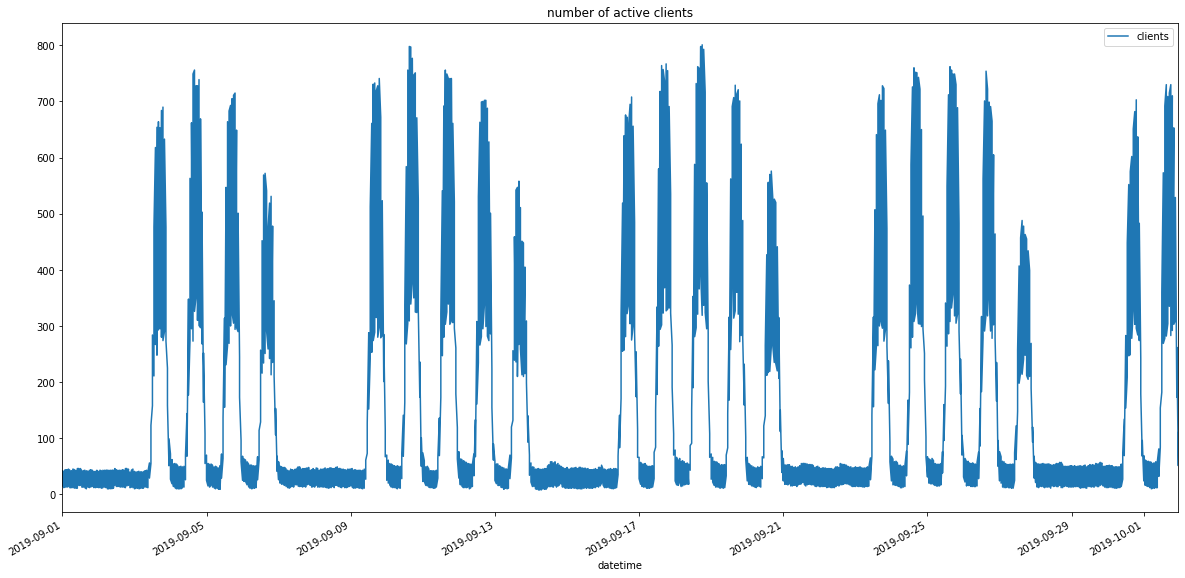

In [8]:
# df_pd = df_pd.astype({'timestamp': 'datetime64[ms]'})



df_pd.plot(x='datetime', y='clients',figsize=(20, 10))
plt.title("number of active clients")

<function matplotlib.pyplot.xticks(ticks=None, labels=None, **kwargs)>

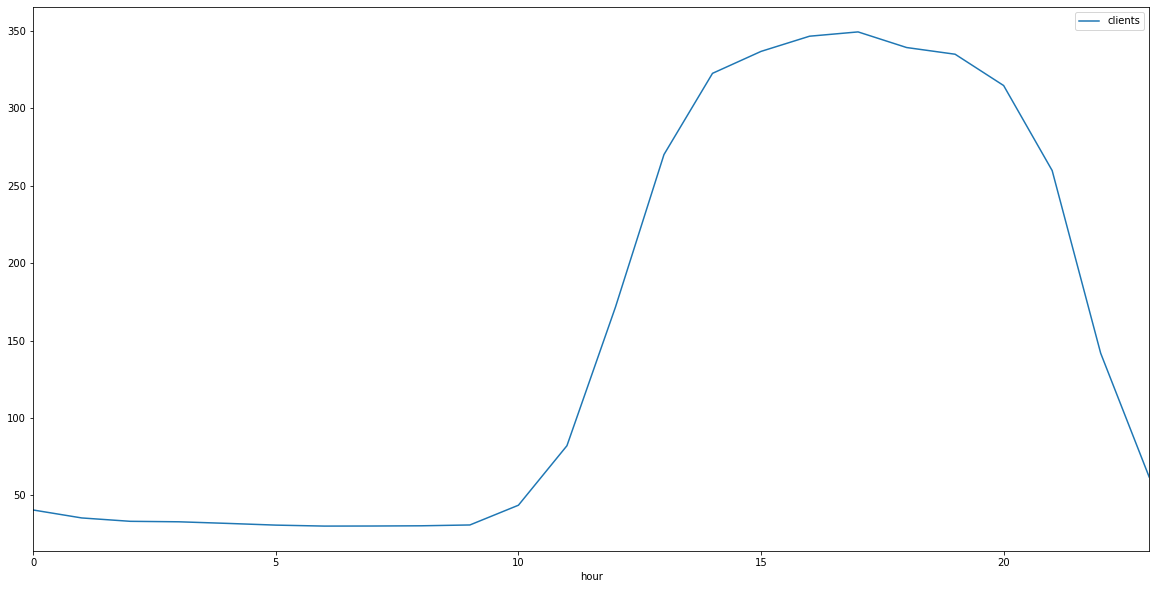

In [9]:
df_pd_g = df_pd[['hour','clients']].groupby("hour").mean()
df_pd_g.plot(figsize=(20, 10))
plt.xticks

In [10]:
y = list(df_pd_g['clients'])
X = list(df_pd_g.index)

Coefficients: [-1.86999424e-02  5.46080908e-01 -2.39106525e+00 -7.35906119e+00
  5.15472211e+01]


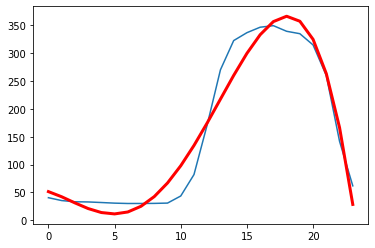

inactive time window


In [11]:
from matplotlib import pyplot
from numpy import polyfit
# series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0)
# # fit polynomial: x^2*b1 + x*b2 + ... + bn
# X = [i%365 for i in range(0, len(series))]
# y = series.values

df_pd["t0"] = df_pd["timestamp"] - df_pd["timestamp"].min()
df_pd =  df_pd.astype({'t0': 'int64'})

degree = 4
# X = df_pd["timestamp"]
# X = df_pd["t0"]
# y = df_pd["clients"]
coef = polyfit(X, y, degree)
print('Coefficients: %s' % coef)
# create curve
curve = list()
for i in range(len(X)):
	value = coef[-1]
	for d in range(degree):
		value += X[i]**(degree-d) * coef[d]
	curve.append(value)
# plot curve over original data
pyplot.plot(df_pd_g['clients'])
pyplot.plot(curve, color='red', linewidth=3)
pyplot.show()
print("inactive time window")

In [12]:
# import numpy as np

inactive_hours = sorted(range(len(curve)), key=lambda k: curve[k])
res = []
for h in inactive_hours[:3]:
    res.append((h, curve[h], X[h]))
    
# print("inactive hours: " + str(inactive_hours))
res
# curve.index(min(curve))


[(5, 11.547933460363133, 5),
 (4, 14.015925223937103, 4),
 (6, 15.03285584020125, 6)]

In [26]:

import matplotlib.pyplot as plt
from numpy import exp, loadtxt, pi, sqrt

from lmfit import Model

# def gauss(x, mu, sigma, A):
#     return A*exp(-(x-mu)**2/2/sigma**2)


# gmodel1 = Model(gauss)
# result1 = gmodel.fit(y, x=X, mu=12, sigma=2, A=10)

# print(result1.fit_report())

# plt.plot(X, y, 'bo')
# # plt.plot(X, result.init_fit, 'k--', label='initial fit')
# plt.plot(X, result1.best_fit, 'r-', label='best fit')
# plt.legend(loc='best')
# plt.xlabel("hour")
# plt.ylabel("Clients")
# plt.show()


[[Model]]
    Model(bimodal)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 338
    # data points      = 24
    # variables        = 6
    chi-square         = 14229.9367
    reduced chi-square = 790.552038
    Akaike info crit   = 165.241186
    Bayesian info crit = 172.309509
[[Variables]]
    mu1:     1.73636166 +/- 2.70840999 (155.98%) (init = 1)
    sigma1:  3.14815258 +/- 2.79971113 (88.93%) (init = 2)
    A1:      39.1727532 +/- 15.4696230 (39.49%) (init = 10)
    mu2:     16.9149674 +/- 0.16139965 (0.95%) (init = 12)
    sigma2:  3.82374149 +/- 0.18408507 (4.81%) (init = 2)
    A2:      380.706593 +/- 13.7183371 (3.60%) (init = 10)
[[Correlations]] (unreported correlations are < 0.100)
    C(mu1, sigma1)    = -0.711
    C(sigma2, A2)     = -0.610
    C(sigma1, A1)     = -0.456
    C(sigma1, sigma2) = -0.317
    C(sigma1, mu2)    =  0.155
    C(sigma1, A2)     =  0.144
    C(A1, sigma2)     =  0.135
    C(mu1, A1)        =  0.119


Text(0.5, 0, 'hour')

Text(0, 0.5, 'Clients')

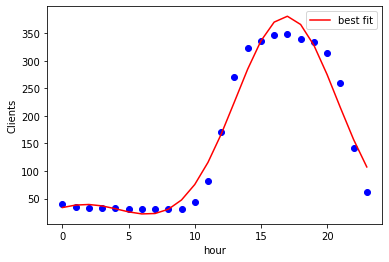

In [31]:

import matplotlib.pyplot as plt
from numpy import exp, loadtxt, pi, sqrt

from lmfit import Model

def gauss(x, mu, sigma, A):
    return A*exp(-(x-mu)**2/2/sigma**2)

def bimodal(x, mu1, sigma1, A1, mu2, sigma2, A2):
    return gauss(x,mu1,sigma1,A1) + gauss(x,mu2,sigma2,A2)


sigma0 = 2 
A_1 = A_2 = max(y)
mu_1 = y.index(max(y))
mu_2 = (mu_1 + 12)/24

gmodel1 = Model(bimodal)
result2 = gmodel.fit(y, x=X, mu1=mu_1, sigma1=sigma0, A1=A_1, mu2=mu_2, sigma2=sigma0, A2=A_2)

print(result.fit_report())

plt.plot(X, y, 'bo')
# plt.plot(X, result.init_fit, 'k--', label='initial fit')
plt.plot(X, result.best_fit, 'r-', label='best fit')
plt.legend(loc='best')
plt.xlabel("hour")
plt.ylabel("Clients")
plt.show()


In [32]:
# !pip install lmfit

curve= result.best_fit
inactive_hours = sorted(range(len(curve)), key=lambda k: curve[k])
res = []
order = 1
for h in inactive_hours[:3]:
    res.append({"hour":h,
                "clients_model":curve[h],
                "clients": X[h],
                "order": order
               }
              )
    order +=1
    
print("Top-3 Inactive hour windows:   " + str(res))

Top-3 Inactive hour windows:   [{'hour': 6, 'clients_model': 22.130842866080453, 'clients': 6, 'order': 1}, {'hour': 7, 'clients_model': 22.881394904468728, 'clients': 7, 'order': 2}, {'hour': 5, 'clients_model': 25.85407937996016, 'clients': 5, 'order': 3}]


In [34]:
np.percentile(y, 10)

30.56612903225806

In [33]:
# result.least_squares()